In [1]:
# 测试环境 - 分步验证
import sys
print("Python 路径:", sys.executable)
print("Python 版本:", sys.version)
print("✅ 基础环境正常")

Python 路径: c:\Users\Ding\anaconda3\envs\autolatex-ocr-cpu\python.exe
Python 版本: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
✅ 基础环境正常


In [2]:
# ============================================
# 本地环境设置
# ============================================

import os
from pathlib import Path
import sys

# ⚠️ 重要：在导入 torch 之前设置环境变量，避免 CUDA 初始化卡住
# 如果 GPU 检查卡住，可以临时注释掉下面这行，强制使用 CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = ''  # 取消注释这行可以强制使用 CPU

# 设置项目根目录（notebooks文件夹的父目录）
ROOT = Path("..").resolve()

# 切换到项目根目录
os.chdir(ROOT)

print("✅ 本地环境设置完成！")
print(f"项目根目录：{ROOT}")
print(f"当前工作目录：{os.getcwd()}")

# 检查GPU可用性（添加异常处理，避免卡住）
print("\n正在检查GPU...")
print("提示：如果这里卡住，请中断运行，然后在代码开头添加：os.environ['CUDA_VISIBLE_DEVICES'] = ''")

try:
    import torch
    print(f"✅ PyTorch 版本: {torch.__version__}")
    
    # 尝试检查GPU（这里可能会卡住）
    try:
        cuda_available = torch.cuda.is_available()
        if cuda_available:
            print(f"✅ GPU可用: {torch.cuda.get_device_name(0)}")
            print(f"   CUDA版本: {torch.version.cuda}")
            print(f"   GPU数量: {torch.cuda.device_count()}")
        else:
            print("⚠️  警告：未检测到GPU，将使用CPU运行（速度较慢）")
    except Exception as cuda_error:
        print(f"⚠️  CUDA检查出错: {cuda_error}")
        print("   将使用CPU模式继续运行")
        
except ImportError:
    print("⚠️  警告：torch未安装，请先安装PyTorch")
except Exception as e:
    print(f"⚠️  导入torch时出错: {e}")
    print("   如果持续卡住，请尝试：")
    print("   1. 中断运行（点击停止按钮）")
    print("   2. 在代码开头添加：os.environ['CUDA_VISIBLE_DEVICES'] = ''")
    print("   3. 重新运行")

# 验证关键文件是否存在
print("\n📋 验证项目文件...")
required_files = [
    ("src/models/unet_baseline.py", "模型文件"),
    ("src/data/dataset.py", "数据集文件"),
    ("src/data/transforms.py", "数据变换文件"),
    ("data/splits/cityscapes_split_seed42.json", "数据划分文件"),
]

all_ok = True
for file_path, description in required_files:
    full_path = ROOT / file_path
    if full_path.exists():
        print(f"✅ {description}: {file_path}")
    else:
        print(f"❌ {description} 缺失: {file_path}")
        all_ok = False

if all_ok:
    print("\n🎉 所有必需文件已就绪，可以开始训练！")
else:
    print("\n⚠️  部分文件缺失，请检查项目结构")



✅ 本地环境设置完成！
项目根目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment
当前工作目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment

正在检查GPU...
提示：如果这里卡住，请中断运行，然后在代码开头添加：os.environ['CUDA_VISIBLE_DEVICES'] = ''
✅ PyTorch 版本: 2.9.1+cu128
✅ GPU可用: NVIDIA GeForce RTX 4060 Laptop GPU
   CUDA版本: 12.8
   GPU数量: 1

📋 验证项目文件...
✅ 模型文件: src/models/unet_baseline.py
✅ 数据集文件: src/data/dataset.py
✅ 数据变换文件: src/data/transforms.py
✅ 数据划分文件: data/splits/cityscapes_split_seed42.json

🎉 所有必需文件已就绪，可以开始训练！


In [3]:
# 导入库
import sys
from pathlib import Path
import os

# 添加项目根目录到路径（适配Colab环境）
# 检测是否在Colab环境中运行
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # 在Colab中，使用之前设置的COLAB_WORK_DIR
    try:
        ROOT = COLAB_WORK_DIR
    except NameError:
        # 如果COLAB_WORK_DIR未定义，使用默认路径
        ROOT = Path("/content/Image-to-Image-Translation-Experiment")
else:
    # 本地环境，使用相对路径
    ROOT = Path("..").resolve()

sys.path.insert(0, str(ROOT))
print(f"项目根目录：{ROOT}")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import json

from src.models.unet_baseline import UNetBaseline
from src.data.dataset import CityscapesDataset
from src.data.transforms import build_transform
from src.eval.metrics import evaluate_batch, calculate_psnr, calculate_ssim, calculate_mae

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据路径
DATA_ROOT = ROOT / "data"
SPLIT_INDEX = ROOT / "data" / "splits" / "cityscapes_split_seed42.json"

# 输出根目录和子目录（与项目整体约定保持一致）
OUTPUT_ROOT = ROOT / "outputs"
CHECKPOINT_DIR = OUTPUT_ROOT / "checkpoints" / "unet_baseline"  # 模型权重
IMAGES_DIR = OUTPUT_ROOT / "images" / "unet_baseline"          # 验证三联图
FIGURES_DIR = OUTPUT_ROOT / "figures" / "unet_baseline"        # 曲线、对比图
LOGS_DIR = OUTPUT_ROOT / "logs" / "unet_baseline"              # 训练日志、历史

# 创建目录
for d in [CHECKPOINT_DIR, IMAGES_DIR, FIGURES_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)



项目根目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment
Using device: cuda


## 1. 测试U-Net模型架构



In [4]:
# 创建模型并测试前向传播
model = UNetBaseline(in_channels=3, out_channels=3).to(device)
model.eval()

# 测试输入
x = torch.randn(1, 3, 256, 256).to(device)
print(f"Input shape: {x.shape}")

with torch.no_grad():
    output = model(x)
    print(f"Output shape: {output.shape}")
    print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
    print(f"Expected range: [-1, 1] (Tanh activation)")

# 计算参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-0.991, 0.991]
Expected range: [-1, 1] (Tanh activation)

Total parameters: 54,414,019
Trainable parameters: 54,414,019


## 2. 准备数据集（三种增强配置）



In [5]:
# 定义三种增强配置
aug_configs = {
    "none": build_transform(
        image_size=256,
        jitter=False,
        horizontal_flip=False,
        color_jitter=None,
        scale_range=None,
        normalize_mode="tanh"
    ),
    "basic": build_transform(
        image_size=256,
        jitter=True,
        horizontal_flip=True,
        color_jitter=None,
        scale_range=None,
        normalize_mode="tanh"
    ),
    "strong": build_transform(
        image_size=256,
        jitter=True,
        horizontal_flip=True,
        color_jitter=(0.2, 0.2, 0.2, 0.05),
        scale_range=(0.8, 1.2),
        normalize_mode="tanh"
    ),
}

# 验证集不使用增强
val_transform = build_transform(
    image_size=256,
    jitter=False,
    horizontal_flip=False,
    color_jitter=None,
    scale_range=None,
    normalize_mode="tanh"
)

print("数据增强配置已准备完成！")



数据增强配置已准备完成！


## 3. 可视化数据增强效果



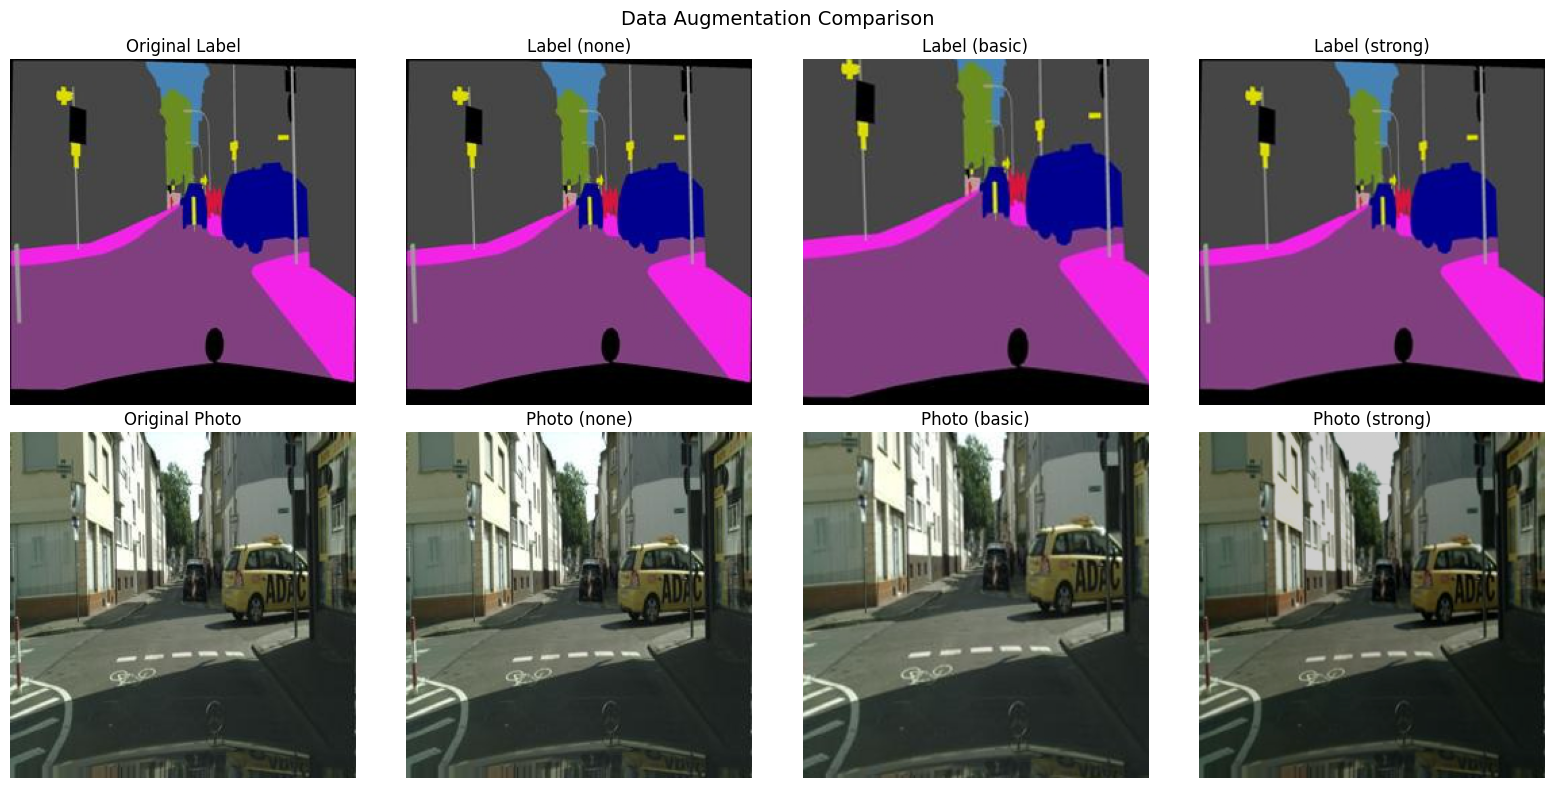

In [6]:
# 加载一个样本进行可视化
test_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="val",
    split_index=SPLIT_INDEX,
    transform=None  # 先不应用transform，看原始图像
)

# 获取原始图像
sample = test_dataset[0]
label_orig = sample["label"]
photo_orig = sample["photo"]

# 可视化原始图像和三种增强配置
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Data Augmentation Comparison", fontsize=14)

# 第一行：Label
axes[0, 0].imshow(label_orig)
axes[0, 0].set_title("Original Label")
axes[0, 0].axis("off")

for col, (aug_name, transform) in enumerate(aug_configs.items(), 1):
    # 应用增强
    label_aug, photo_aug = transform(label_orig.copy(), photo_orig.copy())

    # 转换为图像格式（tensor -> numpy）
    def tensor_to_image(tensor):
        if isinstance(tensor, torch.Tensor):
            img = tensor.permute(1, 2, 0).cpu().numpy()
        else:
            img = np.array(tensor)
        if img.min() < 0:
            img = (img + 1) / 2
        img = np.clip(img, 0, 1)
        return img

    label_img = tensor_to_image(label_aug)
    photo_img = tensor_to_image(photo_aug)

    axes[0, col].imshow(label_img)
    axes[0, col].set_title(f"Label ({aug_name})")
    axes[0, col].axis("off")

    if col == 1:
        axes[1, 0].imshow(photo_orig)
        axes[1, 0].set_title("Original Photo")
        axes[1, 0].axis("off")

    axes[1, col].imshow(photo_img)
    axes[1, col].set_title(f"Photo ({aug_name})")
    axes[1, col].axis("off")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "augmentation_comparison.png", dpi=150, bbox_inches="tight")
plt.show()



In [7]:
def save_triplet(label, generated, ground_truth, save_path):
    """保存三联图：Label / Generated / Ground Truth"""
    def tensor_to_image(tensor):
        if tensor.dim() == 3:
            img = tensor.permute(1, 2, 0).cpu().numpy()
        else:
            img = tensor[0].permute(1, 2, 0).cpu().numpy()
        if img.min() < 0:
            img = (img + 1) / 2
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        return img

    label_img = tensor_to_image(label)
    gen_img = tensor_to_image(generated)
    gt_img = tensor_to_image(ground_truth)

    triplet = np.hstack([label_img, gen_img, gt_img])
    Image.fromarray(triplet).save(save_path)


def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0.0
    num_batches = 0

    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        label = batch["label"].to(device)
        photo = batch["photo"].to(device)

        optimizer.zero_grad()
        generated = model(label)
        loss = criterion(generated, photo)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / num_batches if num_batches > 0 else 0.0


@torch.no_grad()
def validate(model, dataloader, criterion, device, num_samples=10, output_dir=None, aug_mode=""):
    """验证并保存三联图，同时计算评估指标"""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    saved_samples = 0
    
    # 评估指标累计
    total_psnr = 0.0
    total_ssim = 0.0
    total_mae = 0.0
    
    if output_dir is None:
        # 默认将样例三联图保存到 outputs/images/unet_baseline
        output_dir = IMAGES_DIR

    pbar = tqdm(dataloader, desc="Validating")
    for batch in pbar:
        label = batch["label"].to(device)
        photo = batch["photo"].to(device)
        name = batch["name"]

        generated = model(label)
        loss = criterion(generated, photo)

        total_loss += loss.item()
        num_batches += 1
        
        # 计算评估指标
        metrics = evaluate_batch(generated, photo)
        total_psnr += metrics['psnr']
        total_ssim += metrics['ssim']
        total_mae += metrics['mae']

        if saved_samples < num_samples:
            # 保存样例时包含aug_mode标识
            if aug_mode:
                save_path = output_dir / f"sample_{saved_samples:02d}_{aug_mode}.png"
            else:
                save_path = output_dir / f"sample_{saved_samples:02d}.png"
            save_triplet(label, generated, photo, save_path)
            saved_samples += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    avg_psnr = total_psnr / num_batches if num_batches > 0 else 0.0
    avg_ssim = total_ssim / num_batches if num_batches > 0 else 0.0
    avg_mae = total_mae / num_batches if num_batches > 0 else 0.0
    
    return {
        'loss': avg_loss,
        'psnr': avg_psnr,
        'ssim': avg_ssim,
        'mae': avg_mae
    }



In [9]:
# ============================================
# 训练配置 - 修改 aug_mode 来切换增强配置
# ============================================
# 三种配置：'none', 'basic', 'strong'
aug_mode = "none"  # ⚠️ 修改这里来切换配置
epochs = 200
batch_size = 16
lr = 2e-4
start_decay_epoch = 100

# 创建数据集
train_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="train",
    split_index=SPLIT_INDEX,
    transform=aug_configs[aug_mode]
)
val_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="val",
    split_index=SPLIT_INDEX,
    transform=val_transform
)

# 在Colab中，num_workers应该设置为0以避免多进程问题
# 在本地环境中可以使用2或更多
num_workers = 0  # 在 Colab 上通常设置为 2 是安全的
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True  # 建议开启，加速数据转入GPU
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 创建模型
model = UNetBaseline(in_channels=3, out_channels=3).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

# 学习率调度
def get_lr_scheduler(optimizer, num_epochs, start_decay_epoch):
    def lr_lambda(epoch):
        if epoch < start_decay_epoch:
            return 1.0
        else:
            return 1.0 - (epoch - start_decay_epoch) / (num_epochs - start_decay_epoch)
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, epochs, start_decay_epoch)

# 训练循环（记录评估指标）
train_losses = []
val_losses = []
val_psnrs = []
val_ssims = []
val_maes = []

print(f"🚀 Starting training with augmentation: {aug_mode}")
print(f"   Configuration: {aug_mode}")
print(f"   Epochs: {epochs}, Batch size: {batch_size}, LR: {lr}")

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_metrics = validate(model, val_loader, criterion, device, num_samples=10, aug_mode=aug_mode)

    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_metrics['loss'])
    val_psnrs.append(val_metrics['psnr'])
    val_ssims.append(val_metrics['ssim'])
    val_maes.append(val_metrics['mae'])

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_metrics['loss']:.4f}, "
              f"PSNR: {val_metrics['psnr']:.2f}dB, "
              f"SSIM: {val_metrics['ssim']:.4f}, "
              f"MAE: {val_metrics['mae']:.4f}, "
              f"LR: {current_lr:.6f}")

        # 保存checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_metrics['loss'],
            "val_psnr": val_metrics['psnr'],
            "val_ssim": val_metrics['ssim'],
            "val_mae": val_metrics['mae'],
        }, CHECKPOINT_DIR / f"checkpoint_{aug_mode}_epoch_{epoch:03d}.pth")

# 保存最终模型和训练历史
torch.save({
    "epoch": epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_psnrs": val_psnrs,
    "val_ssims": val_ssims,
    "val_maes": val_maes,
    "aug_mode": aug_mode,
}, CHECKPOINT_DIR / f"model_{aug_mode}_final.pth")

# 保存训练历史为JSON（方便后续对比）
import json
history = {
    "aug_mode": aug_mode,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_psnrs": val_psnrs,
    "val_ssims": val_ssims,
    "val_maes": val_maes,
}
with open(LOGS_DIR / f"history_{aug_mode}.json", "w") as f:
    json.dump(history, f, indent=2)

print(f"\n✅ Training complete! ({aug_mode})")
print(f"   Final Val Loss: {val_losses[-1]:.4f}")
print(f"   Final PSNR: {val_psnrs[-1]:.2f}dB")
print(f"   Final SSIM: {val_ssims[-1]:.4f}")
print(f"   Final MAE: {val_maes[-1]:.4f}")



🚀 Starting training with augmentation: none
   Configuration: none
   Epochs: 200, Batch size: 16, LR: 0.0002


Validating: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Epoch 10/200 - Train Loss: 0.1720, Val Loss: 0.2040, PSNR: 17.20dB, SSIM: 0.4915, MAE: 0.1020, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 20/200 - Train Loss: 0.1418, Val Loss: 0.2072, PSNR: 17.00dB, SSIM: 0.5046, MAE: 0.1036, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


Epoch 30/200 - Train Loss: 0.1240, Val Loss: 0.2108, PSNR: 16.89dB, SSIM: 0.5044, MAE: 0.1054, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Epoch 40/200 - Train Loss: 0.1108, Val Loss: 0.2121, PSNR: 16.87dB, SSIM: 0.5016, MAE: 0.1061, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Epoch 50/200 - Train Loss: 0.1009, Val Loss: 0.2103, PSNR: 16.88dB, SSIM: 0.5033, MAE: 0.1052, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:32<00:00,  1.00s/it]


Epoch 60/200 - Train Loss: 0.0944, Val Loss: 0.2118, PSNR: 16.79dB, SSIM: 0.4949, MAE: 0.1059, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:33<00:00,  1.06s/it]


Epoch 70/200 - Train Loss: 0.0888, Val Loss: 0.2102, PSNR: 16.87dB, SSIM: 0.4969, MAE: 0.1051, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Epoch 80/200 - Train Loss: 0.0846, Val Loss: 0.2130, PSNR: 16.79dB, SSIM: 0.4885, MAE: 0.1065, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:32<00:00,  1.00s/it]


Epoch 90/200 - Train Loss: 0.0808, Val Loss: 0.2118, PSNR: 16.86dB, SSIM: 0.4916, MAE: 0.1059, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


Epoch 100/200 - Train Loss: 0.0777, Val Loss: 0.2121, PSNR: 16.78dB, SSIM: 0.4870, MAE: 0.1061, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


Epoch 110/200 - Train Loss: 0.0745, Val Loss: 0.2137, PSNR: 16.70dB, SSIM: 0.4806, MAE: 0.1069, LR: 0.000180


Validating: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


Epoch 120/200 - Train Loss: 0.0715, Val Loss: 0.2124, PSNR: 16.76dB, SSIM: 0.4825, MAE: 0.1062, LR: 0.000160


Validating: 100%|██████████| 32/32 [00:33<00:00,  1.03s/it]


Epoch 130/200 - Train Loss: 0.0689, Val Loss: 0.2130, PSNR: 16.72dB, SSIM: 0.4790, MAE: 0.1065, LR: 0.000140


Validating: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Epoch 140/200 - Train Loss: 0.0667, Val Loss: 0.2133, PSNR: 16.71dB, SSIM: 0.4746, MAE: 0.1066, LR: 0.000120


Validating: 100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch 150/200 - Train Loss: 0.0648, Val Loss: 0.2137, PSNR: 16.72dB, SSIM: 0.4758, MAE: 0.1068, LR: 0.000100


Validating: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Epoch 160/200 - Train Loss: 0.0632, Val Loss: 0.2144, PSNR: 16.68dB, SSIM: 0.4729, MAE: 0.1072, LR: 0.000080


Validating: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


Epoch 170/200 - Train Loss: 0.0618, Val Loss: 0.2151, PSNR: 16.65dB, SSIM: 0.4689, MAE: 0.1075, LR: 0.000060


Validating: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


Epoch 180/200 - Train Loss: 0.0605, Val Loss: 0.2151, PSNR: 16.64dB, SSIM: 0.4694, MAE: 0.1075, LR: 0.000040


Validating: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


Epoch 190/200 - Train Loss: 0.0598, Val Loss: 0.2153, PSNR: 16.63dB, SSIM: 0.4685, MAE: 0.1077, LR: 0.000020


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch 200/200 - Train Loss: 0.0591, Val Loss: 0.2156, PSNR: 16.62dB, SSIM: 0.4671, MAE: 0.1078, LR: 0.000000

✅ Training complete! (none)
   Final Val Loss: 0.2156
   Final PSNR: 16.62dB
   Final SSIM: 0.4671
   Final MAE: 0.1078


### 5.3 强增强配置

> **注意**：训练强增强配置时，修改 `aug_mode = "strong"`。



## 6. 可视化训练结果

### 6.1 训练损失曲线



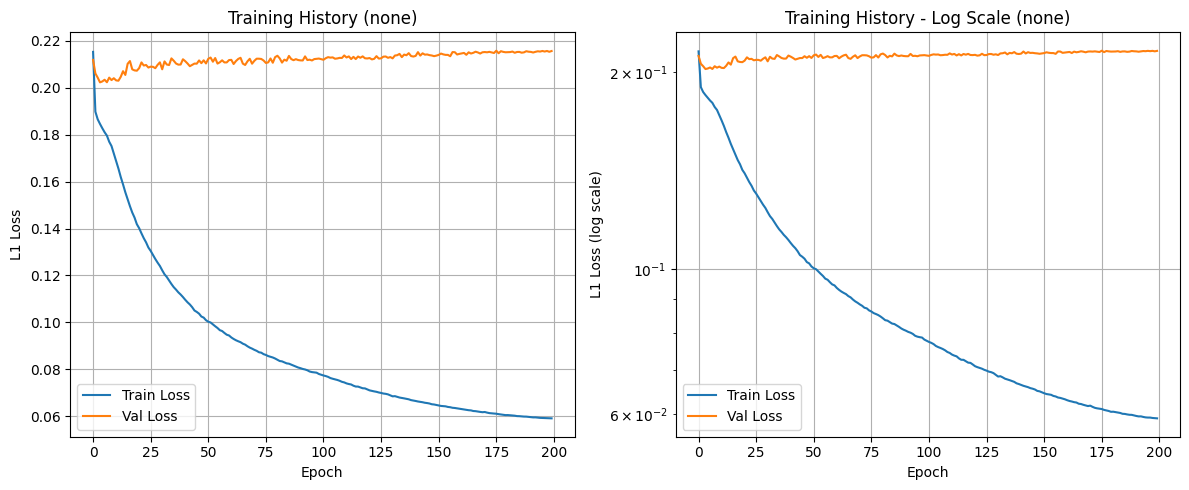

In [10]:
# 加载训练历史（如果有多个配置，可以加载并对比）
# 这里展示如何绘制损失曲线

# 示例：绘制单个配置的损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title(f"Training History ({aug_mode})")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss (log scale)")
plt.yscale("log")
plt.title(f"Training History - Log Scale ({aug_mode})")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f"training_curve_{aug_mode}.png", dpi=150, bbox_inches="tight")
plt.show()



### 6.2 生成结果可视化



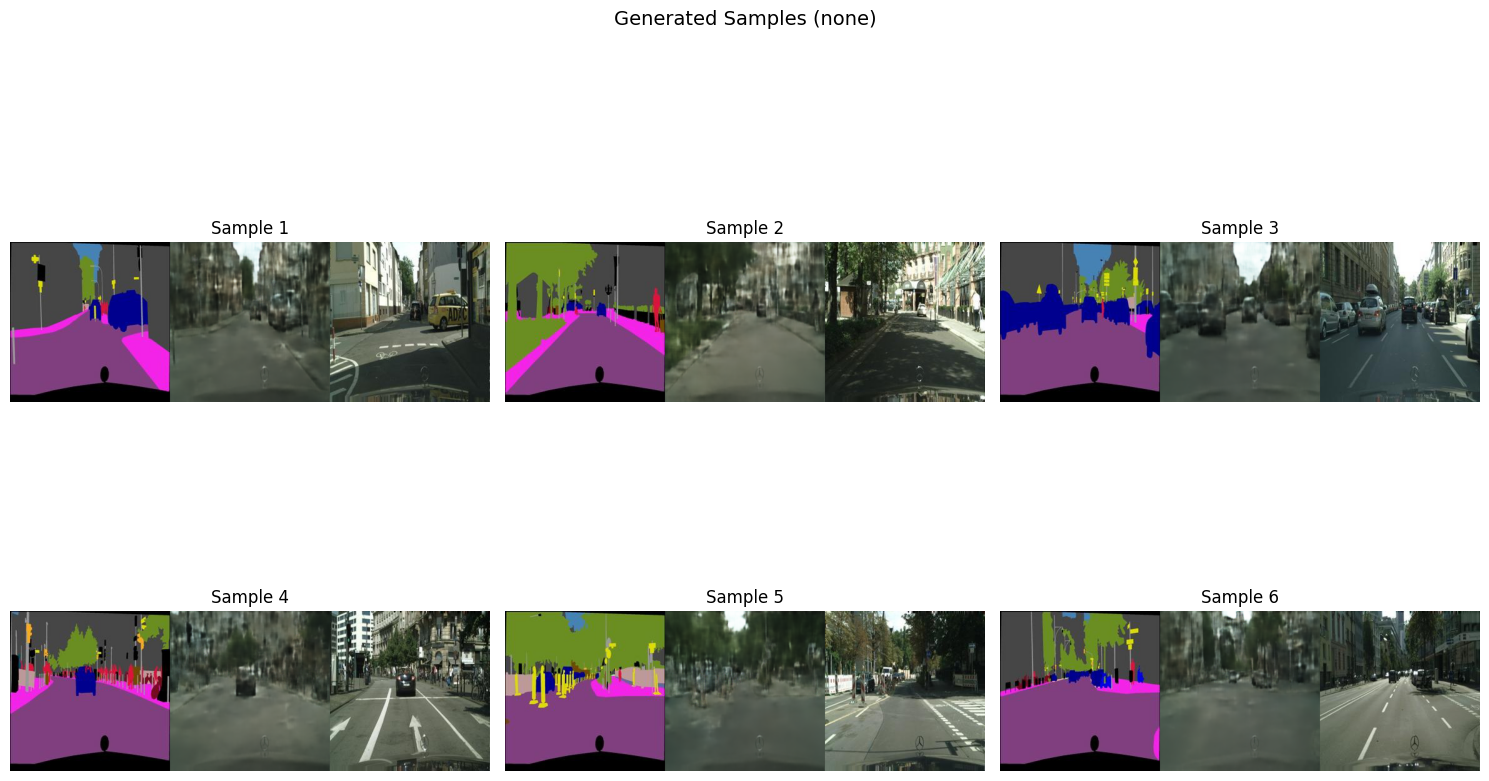

In [11]:
# 加载保存的三联图并展示
import glob

sample_images = sorted(glob.glob(str(IMAGES_DIR / "sample_*.png")))[:6]

if sample_images:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Generated Samples ({aug_mode})", fontsize=14)

    for idx, img_path in enumerate(sample_images):
        row = idx // 3
        col = idx % 3
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Sample {idx + 1}")
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"samples_{aug_mode}.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No sample images found. Run validation to generate samples.")



## 7. 数据增强消融实验完整流程

### 7.1 消融实验步骤说明

**重要：请按顺序完成以下步骤**

1. **第一步**：运行上面的训练代码（Cell 13），设置 `aug_mode = "none"`，完成无增强训练
2. **第二步**：修改 `aug_mode = "basic"`，重新运行 Cell 13，完成基础增强训练
3. **第三步**：修改 `aug_mode = "strong"`，重新运行 Cell 13，完成强增强训练
4. **第四步**：运行下面的对比分析代码（Cell 20+），生成消融实验报告

**注意**：每次训练会保存：
- 模型文件：`model_{aug_mode}_final.pth`
- 训练历史：`history_{aug_mode}.json`
- 损失曲线图：`training_curve_{aug_mode}.png`
- 生成样例：`sample_*.png`

---

### 7.2 加载所有配置的训练历史并对比



In [ ]:
# aug_modes = ["none", "basic", "strong"]
# histories = {}

# for aug_mode in aug_modes:
#     history_path = LOGS_DIR / f"history_{aug_mode}.json"
#     if history_path.exists():
#         with open(history_path, "r") as f:
#             histories[aug_mode] = json.load(f)
#         print(f"✅ 已加载 {aug_mode} 的训练历史")
#     else:
#         print(f"⚠️  未找到 {aug_mode} 的训练历史: {history_path}")

# if len(histories) == 0:
#     print("\n❌ 未找到任何训练历史！请先完成训练。")
# else:
#     print(f"\n📊 已加载 {len(histories)} 个配置的训练历史")


### 7.3 对比损失曲线


In [ ]:
# # 绘制三种配置的损失曲线对比
# if len(histories) > 0:
#     fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
#     # 训练损失对比
#     ax = axes[0, 0]
#     for aug_mode, history in histories.items():
#         epochs = range(1, len(history['train_losses']) + 1)
#         ax.plot(epochs, history['train_losses'], label=f"Train ({aug_mode})", linewidth=2)
#     ax.set_xlabel("Epoch")
#     ax.set_ylabel("L1 Loss")
#     ax.set_title("Training Loss Comparison")
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # 验证损失对比
#     ax = axes[0, 1]
#     for aug_mode, history in histories.items():
#         epochs = range(1, len(history['val_losses']) + 1)
#         ax.plot(epochs, history['val_losses'], label=f"Val ({aug_mode})", linewidth=2)
#     ax.set_xlabel("Epoch")
#     ax.set_ylabel("L1 Loss")
#     ax.set_title("Validation Loss Comparison")
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # PSNR对比
#     ax = axes[1, 0]
#     for aug_mode, history in histories.items():
#         epochs = range(1, len(history['val_psnrs']) + 1)
#         ax.plot(epochs, history['val_psnrs'], label=f"{aug_mode}", linewidth=2, marker='o', markersize=3)
#     ax.set_xlabel("Epoch")
#     ax.set_ylabel("PSNR (dB)")
#     ax.set_title("PSNR Comparison (Higher is Better)")
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # SSIM对比
#     ax = axes[1, 1]
#     for aug_mode, history in histories.items():
#         epochs = range(1, len(history['val_ssims']) + 1)
#         ax.plot(epochs, history['val_ssims'], label=f"{aug_mode}", linewidth=2, marker='s', markersize=3)
#     ax.set_xlabel("Epoch")
#     ax.set_ylabel("SSIM")
#     ax.set_title("SSIM Comparison (Higher is Better)")
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig(FIGURES_DIR / "ablation_comparison_curves.png", dpi=150, bbox_inches="tight")
#     plt.show()
# else:
#     print("请先完成训练并加载训练历史")


### 7.4 最终指标对比表


In [ ]:
# 生成最终指标对比表
if len(histories) > 0:
    import pandas as pd
    
    results = []
    for aug_mode, history in histories.items():
        final_epoch = len(history['val_losses']) - 1
        results.append({
            "Augmentation": aug_mode,
            "Final Val Loss": f"{history['val_losses'][final_epoch]:.4f}",
            "Final PSNR (dB)": f"{history['val_psnrs'][final_epoch]:.2f}",
            "Final SSIM": f"{history['val_ssims'][final_epoch]:.4f}",
            "Final MAE": f"{history['val_maes'][final_epoch]:.4f}",
            "Best PSNR (dB)": f"{max(history['val_psnrs']):.2f}",
            "Best SSIM": f"{max(history['val_ssims']):.4f}",
            "Best Epoch (PSNR)": history['val_psnrs'].index(max(history['val_psnrs'])) + 1,
        })
    
    df = pd.DataFrame(results)
    print("\n" + "="*80)
    print("📊 数据增强消融实验最终结果对比")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # 保存为CSV（训练日志）
    df.to_csv(LOGS_DIR / "ablation_results.csv", index=False)
    print(f"\n✅ 结果已保存到: {LOGS_DIR / 'ablation_results.csv'}")
    
    # 可视化指标对比（柱状图）
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    aug_names = [r['Augmentation'] for r in results]
    psnrs = [float(r['Final PSNR (dB)']) for r in results]
    ssims = [float(r['Final SSIM']) for r in results]
    maes = [float(r['Final MAE']) for r in results]
    
    # PSNR对比
    axes[0].bar(aug_names, psnrs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_ylabel("PSNR (dB)")
    axes[0].set_title("PSNR Comparison (Higher is Better)")
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(psnrs):
        axes[0].text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')
    
    # SSIM对比
    axes[1].bar(aug_names, ssims, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1].set_ylabel("SSIM")
    axes[1].set_title("SSIM Comparison (Higher is Better)")
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(ssims):
        axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom')
    
    # MAE对比
    axes[2].bar(aug_names, maes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[2].set_ylabel("MAE")
    axes[2].set_title("MAE Comparison (Lower is Better)")
    axes[2].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(maes):
        axes[2].text(i, v + 0.002, f"{v:.4f}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "ablation_metrics_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("请先完成训练并加载训练历史")


### 7.5 生成结果可视化对比


In [ ]:
# # 对比三种配置的生成结果
# if len(histories) > 0:
#     import glob
    
#     # 为每种配置加载样例图像
#     sample_dict = {}
#     for aug_mode in aug_modes:
#         samples = sorted(glob.glob(str(IMAGES_DIR / f"sample_*_{aug_mode}.png")))
#         if not samples:
#             # 尝试查找通用格式
#             samples = sorted(glob.glob(str(IMAGES_DIR / f"sample_*.png")))
#         sample_dict[aug_mode] = samples[:6]  # 每种配置取前6张
    
#     # 如果找到了样例，进行可视化
#     if any(sample_dict.values()):
#         num_samples = min(len(samples) for samples in sample_dict.values() if samples)
#         if num_samples > 0:
#             fig, axes = plt.subplots(num_samples, len(aug_modes) + 1, figsize=(20, 4 * num_samples))
#             fig.suptitle("Generated Samples Comparison: Label | None | Basic | Strong", fontsize=16)
            
#             for row in range(num_samples):
#                 # 第一列：Label（从第一个配置获取）
#                 for aug_mode in aug_modes:
#                     if sample_dict[aug_mode]:
#                         label_img = Image.open(sample_dict[aug_mode][row])
#                         # 提取左侧的label部分
#                         w, h = label_img.size
#                         label_part = label_img.crop((0, 0, w // 3, h))
#                         axes[row, 0].imshow(label_part)
#                         axes[row, 0].set_title("Label" if row == 0 else "")
#                         axes[row, 0].axis("off")
#                         break
                
#                 # 其他列：不同配置的生成结果
#                 for col, aug_mode in enumerate(aug_modes, 1):
#                     if sample_dict[aug_mode] and row < len(sample_dict[aug_mode]):
#                         img = Image.open(sample_dict[aug_mode][row])
#                         # 提取中间的生成结果部分
#                         w, h = img.size
#                         gen_part = img.crop((w // 3, 0, 2 * w // 3, h))
#                         axes[row, col].imshow(gen_part)
#                         if row == 0:
#                             axes[row, col].set_title(f"{aug_mode.upper()}")
#                         axes[row, col].axis("off")
            
#             plt.tight_layout()
#             plt.savefig(FIGURES_DIR / "ablation_samples_comparison.png", dpi=150, bbox_inches="tight")
#             plt.show()
#         else:
#             print("未找到足够的样例图像")
#     else:
#         print("⚠️  未找到样例图像。请确保训练时保存了样例（validate函数中的num_samples > 0）")
# else:
#     print("请先完成训练并加载训练历史")


### 7.6 消融实验总结与分析

运行下面的代码生成分析报告：


In [ ]:
# # 生成消融实验分析报告
# if len(histories) > 0:
#     report = []
#     report.append("="*80)
#     report.append("数据增强消融实验分析报告")
#     report.append("="*80)
#     report.append("")
    
#     # 配置说明
#     report.append("【实验配置】")
#     report.append(f"  模型: U-Net Baseline (仅L1损失)")
#     report.append(f"  训练轮数: 200 epochs")
#     report.append(f"  学习率: 2e-4 (从epoch 100开始线性衰减)")
#     report.append(f"  Batch size: 16")
#     report.append("")
    
#     # 增强配置说明
#     report.append("【数据增强配置】")
#     report.append("  1. none: 无增强（仅resize到256x256）")
#     report.append("  2. basic: 基础增强（随机jitter + 水平翻转）")
#     report.append("  3. strong: 强增强（jitter + 翻转 + 颜色抖动 + 随机缩放）")
#     report.append("")
    
#     # 结果对比
#     report.append("【实验结果对比】")
#     for aug_mode, history in histories.items():
#         final_idx = len(history['val_losses']) - 1
#         best_psnr_idx = history['val_psnrs'].index(max(history['val_psnrs']))
        
#         report.append(f"\n  {aug_mode.upper()} 配置:")
#         report.append(f"    最终验证损失: {history['val_losses'][final_idx]:.4f}")
#         report.append(f"    最终PSNR: {history['val_psnrs'][final_idx]:.2f} dB")
#         report.append(f"    最终SSIM: {history['val_ssims'][final_idx]:.4f}")
#         report.append(f"    最终MAE: {history['val_maes'][final_idx]:.4f}")
#         report.append(f"    最佳PSNR: {max(history['val_psnrs']):.2f} dB (Epoch {best_psnr_idx + 1})")
#         report.append(f"    最佳SSIM: {max(history['val_ssims']):.4f}")
    
#     # 分析
#     report.append("\n【分析结论】")
    
#     # 找出最佳配置
#     best_psnr_config = max(histories.items(), key=lambda x: max(x[1]['val_psnrs']))
#     best_ssim_config = max(histories.items(), key=lambda x: max(x[1]['val_ssims']))
#     best_mae_config = min(histories.items(), key=lambda x: x[1]['val_maes'][-1])
    
#     report.append(f"  1. PSNR最佳配置: {best_psnr_config[0]} ({max(best_psnr_config[1]['val_psnrs']):.2f} dB)")
#     report.append(f"  2. SSIM最佳配置: {best_ssim_config[0]} ({max(best_ssim_config[1]['val_ssims']):.4f})")
#     report.append(f"  3. MAE最佳配置: {best_mae_config[0]} ({best_mae_config[1]['val_maes'][-1]:.4f})")
#     report.append("")
    
#     # 训练稳定性分析
#     report.append("【训练稳定性分析】")
#     for aug_mode, history in histories.items():
#         val_loss_range = max(history['val_losses']) - min(history['val_losses'])
#         val_loss_std = np.std(history['val_losses'][-50:])  # 最后50个epoch的标准差
#         report.append(f"  {aug_mode}: 验证损失波动范围={val_loss_range:.4f}, 后期标准差={val_loss_std:.4f}")
    
#     report.append("")
#     report.append("="*80)
    
#     # 打印报告
#     report_text = "\n".join(report)
#     print(report_text)
    
#     # 保存报告到日志目录
#     with open(LOGS_DIR / "ablation_report.txt", "w", encoding="utf-8") as f:
#         f.write(report_text)
#     print(f"\n✅ 分析报告已保存到: {LOGS_DIR / 'ablation_report.txt'}")
# else:
#     print("请先完成训练并加载训练历史")
